In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
df = pd.read_csv("data_regression.csv")

df.head()

,year,customer_id,phone_no,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,2015,100198,409-8743,Female,36,62,no,no,148.35,12.2,16.81,82,1,4.0,1,0.0
1,2015,100643,340-5930,Female,39,149,no,no,294.45,7.7,33.37,87,3,3.0,2,0.0
2,2015,100756,372-3750,Female,65,126,no,no,87.30,11.9,9.89,91,1,4.0,5,1.0
3,2015,101595,331-4902,Female,24,131,no,yes,321.30,9.5,36.41,102,4,3.0,3,0.0
4,2015,101653,351-8398,Female,40,191,no,no,243.00,10.9,27.54,83,7,3.0,1,0.0


In [3]:
#drop all null values

df = df.dropna()

In [4]:
df["churn"].value_counts()

churn
0.0    1665
1.0     253
Name: count, dtype: int64

In [5]:
#balance the response variable data using SMOTE


def balance_data(df, class_col, cols_to_exclude):
    
    """
          Balances the class distribution in the given dataframe using SMOTE.
        
          Args:
              df (pandas.DataFrame): The dataframe containing the data.
              class_col (str): The name of the column containing the class labels.
              cols_to_exclude (list): List of column names to exclude from feature selection.
        
          Returns:
              pandas.DataFrame: The dataframe with balanced class distribution.
    """
    
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE
    cols = df.select_dtypes(include=np.number).columns.tolist()

    X = df[cols]
    X = X[X.columns.difference([class_col])]
    X = X[X.columns.difference(cols_to_exclude)]

    y = df[class_col]

    global X_train, X_test, y_train, y_test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    sm = SMOTE(random_state=0, sampling_strategy=1.0)
    X_train,y_train = sm.fit_resample(X_train, y_train)

In [6]:
df["churn"].value_counts()

churn
0.0    1665
1.0     253
Name: count, dtype: int64

In [7]:
#run model

def run_model(X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import roc_auc_score, classification_report

    global dectree
    dectree = DecisionTreeClassifier(random_state=13, criterion="gini")
    dectree.fit(X_train, y_train)

    global y_pred
    y_pred = dectree.predict(X_test)

    
    print("Classification report is", classification_report(y_test, y_pred))
    print("Decision Tree Classifier roc_auc_score is", roc_auc_score(y_test, y_pred))
    

In [39]:
balance_data(df, class_col="churn", cols_to_exclude=["year", "customer_id", "phone_no"])
run_model(X_train, X_test, y_train, y_test)

Classification report is               precision    recall  f1-score   support

         0.0       0.93      0.86      0.90       513
         1.0       0.31      0.51      0.38        63

    accuracy                           0.82       576
   macro avg       0.62      0.68      0.64       576
weighted avg       0.87      0.82      0.84       576

Decision Tree Classifier roc_auc_score is 0.6837928153717627


In [52]:
def roc_under_curve(model, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # Calculate AUC score
    logit_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Setting the graph area
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Plotting the worst line possible
    plt.plot([0, 1], [0, 1], "b--")

    # Plotting the ROC curve
    plt.plot(fpr, tpr, color="darkorange", label="Model (area = %0.2f)" % logit_roc_auc)

    # Adding labels and etc
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [53]:
def confusion_matrix(y_test, y_pred):
    
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)

    tp, fp, tn, fn = confusion_matrix.ravel()

    print("True Positive: ", tp)
    print("False Positive: ", fp)
    print("True Negative: ", tn)
    print("False Positive: ", fn)

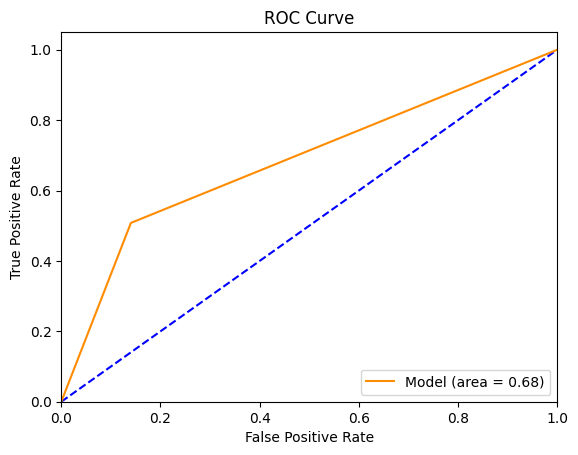

True Positive:  441
False Positive:  72
True Negative:  31
False Positive:  32


In [54]:
roc_under_curve(dectree, X_test, y_test)
confusion_matrix(y_test, y_pred)

In [59]:
#plot decision tree

def plot_model(model, class_names, max_depth=None, figsize=(20, 20), fontsize=1):
    from sklearn import tree

    plt.figure(figsize=figsize)
    tree.plot_tree(dectree,
                   feature_names= dectree.feature_names_in_,
                   fontsize=fontsize,
                   max_depth=max_depth,
                   class_names= class_names,
                   filled = True
                   )

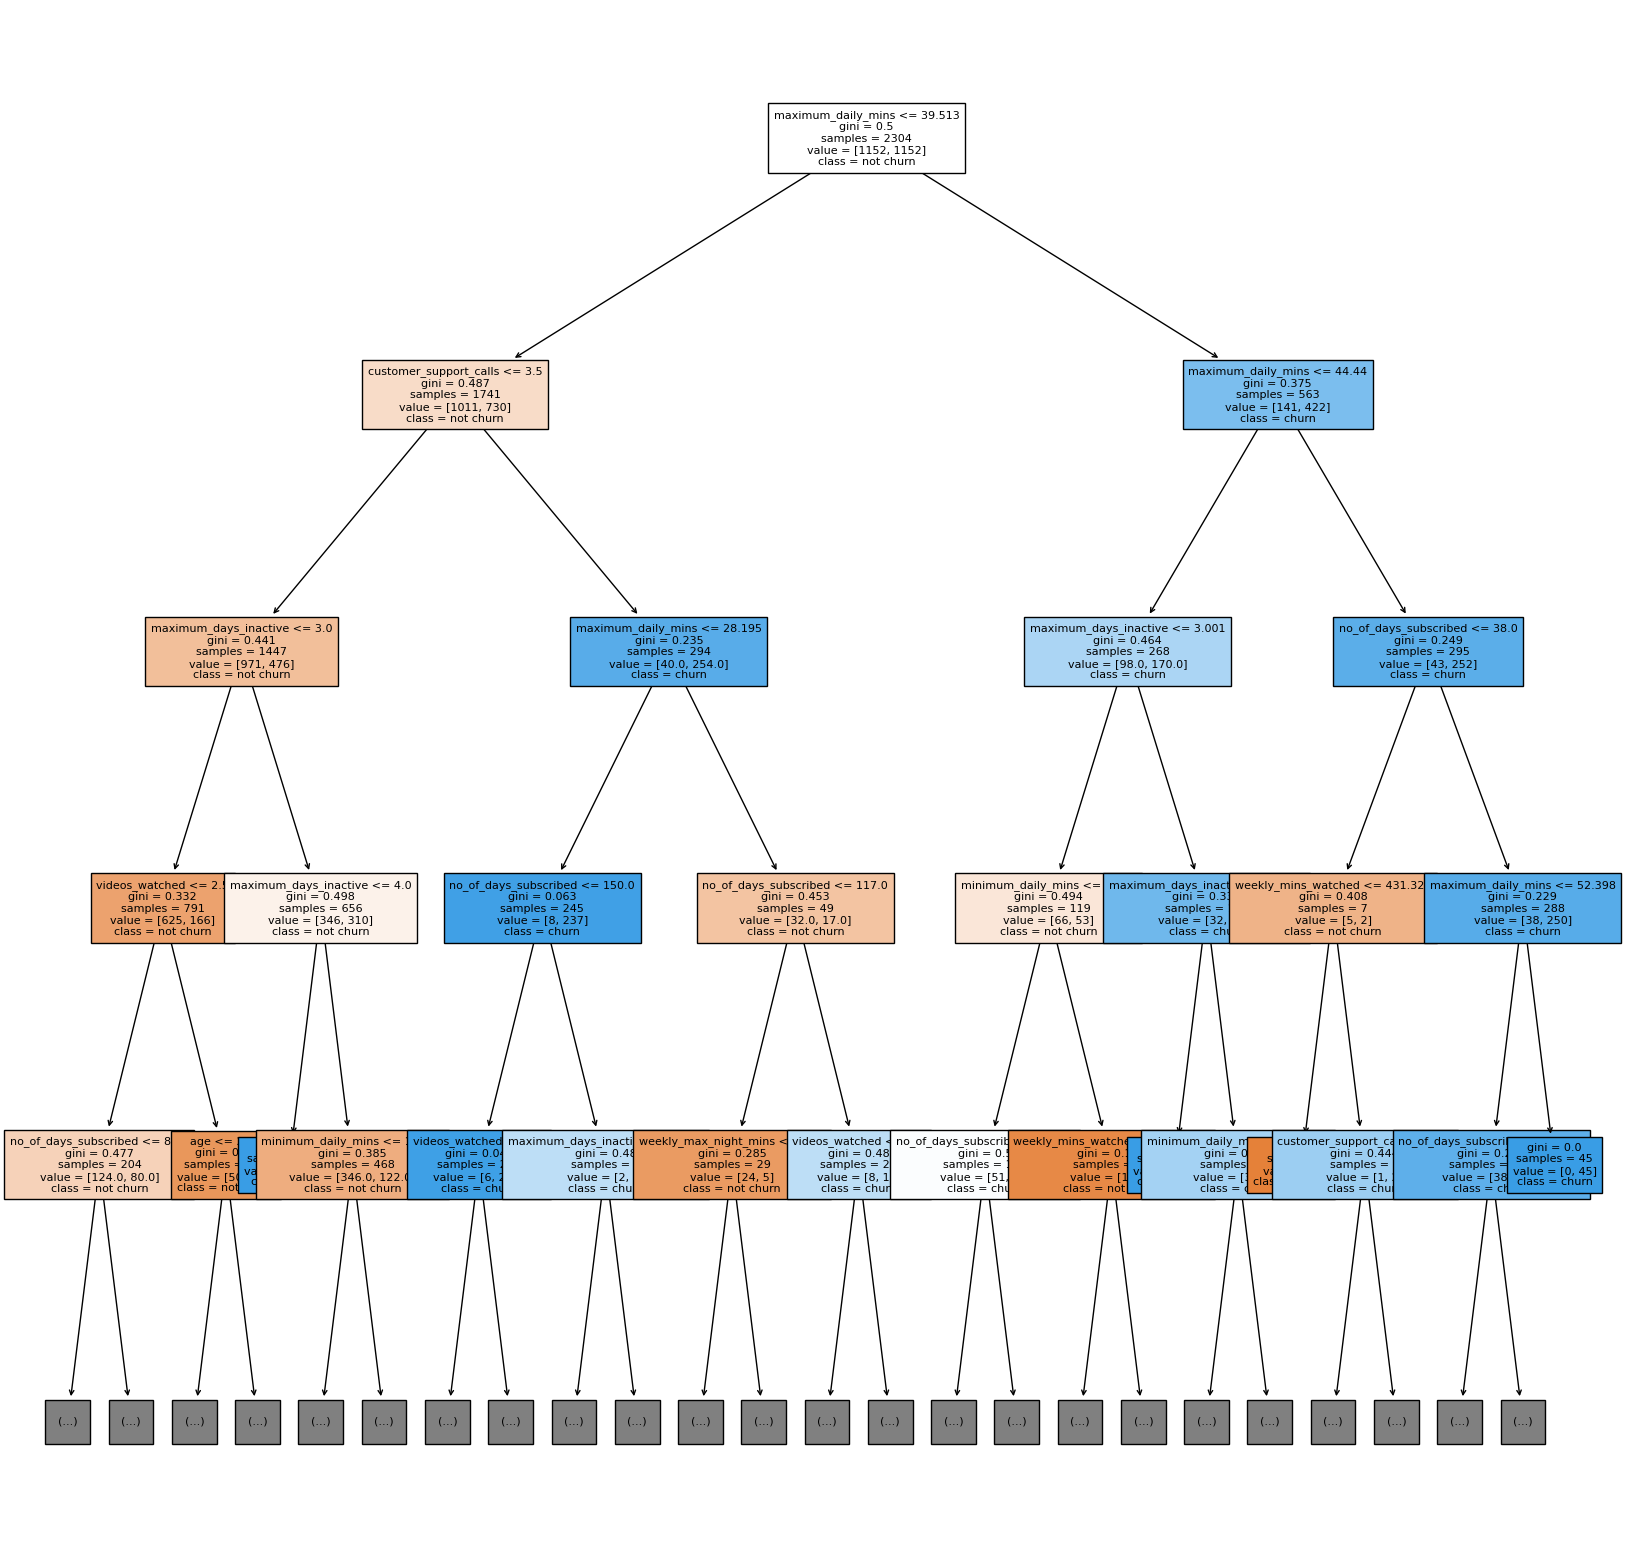

In [66]:
plot_model(dectree, class_names=["not churn", "churn"], max_depth=4, figsize=(20, 20), fontsize=8)

In [71]:
# feature importance

def plot_feature_importance(model):
    feature_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
    feature_importances = feature_importances.sort_values(axis=0, ascending=False)
    fig, ax = plt.subplots()
    feature_importances.plot.bar()
    ax.set_title("Features Importances")
    fig.tight_layout()

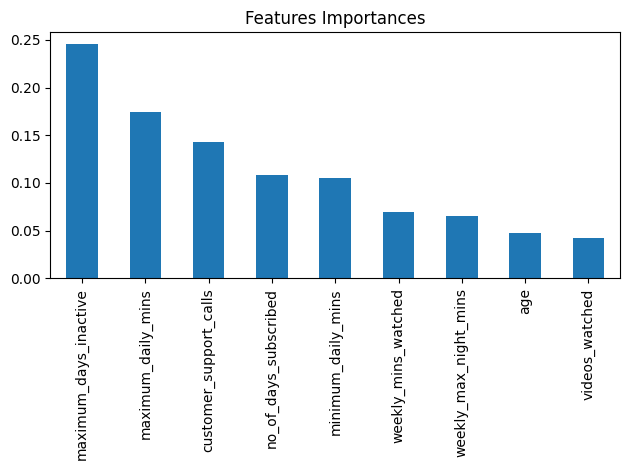

In [72]:
plot_feature_importance(dectree)